# LDA 토픽 모델링


### 단어 토큰화, dictionary, 말뭉치 준비

In [4]:
import pickle

with open('./drive/MyDrive/filtered_soynlp_cafe.pkl','rb') as input_file:
    filtered_nouns_cafe = pickle.load(input_file)

In [5]:
filtered_nouns_cafe.head()

0              [이산화탄소, 자료, 설명, 유익, 문제, 생각, 이론, 필자, 십대]
2    [바디워시, 바디로션, 일랑향, 클렌져, 브러쉬, 클렌저, 비누, 사용, 샤워, 처...
4    [진맛과, 천혜향, 멜론, 배송, 선별, 마트, 신선, 구독, 확인, 과일, 명인,...
6    [참여연대, 사무국장, 플라스틱, 쓰담쓰담, 일회용품, 소비자, 워크숍, 반찬통, ...
7                                                 [박스]
dtype: object

In [ ]:
token_doc_cafe = (filtered_nouns_cafe)

In [ ]:
from gensim import corpora

dictionary_cafe = corpora.Dictionary(filtered_nouns_cafe)
corpus_cafe = [dictionary_cafe.doc2bow(text) for text in filtered_nouns_cafe]

(정수 인코딩값, 빈도수)

In [ ]:
corpus_cafe[:1]

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1)]]

#### 모델 적합

In [ ]:
import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
import gensim

k=5
lda_model_final_cafe = gensim.models.LdaMulticore(corpus=corpus_cafe,
                                           id2word=dictionary_cafe,
                                           num_topics=k,
                                           random_state=100,
                                           chunksize=100,#num of docs to be used each training
                                           passes=100, #num of passes thru corpus during training
                                           alpha=0.01,
                                           eta='auto')

In [ ]:
topics = lda_model_final_cafe.print_topics(num_words=6)
for topic in topics:
    print(topic)

(0, '0.025*"지구" + 0.025*"제품" + 0.025*"실천" + 0.017*"플라스틱" + 0.009*"워크숍" + 0.009*"운동"')
(1, '0.025*"사용" + 0.014*"성분" + 0.014*"샤워" + 0.014*"여름" + 0.014*"이상" + 0.014*"일랑향"')
(2, '0.028*"문제" + 0.028*"제품" + 0.019*"생각" + 0.019*"박스" + 0.010*"봄날" + 0.010*"교육"')
(3, '0.009*"구독" + 0.009*"과일" + 0.009*"마트" + 0.009*"멜론" + 0.009*"건강" + 0.009*"확인"')
(4, '0.051*"사용" + 0.015*"사람" + 0.015*"거절" + 0.015*"국민" + 0.015*"재사용" + 0.015*"진행"')


In [ ]:
coherence_model_lda_cafe = CoherenceModel(model=lda_model_final_cafe, texts=token_doc_cafe, \
                                     dictionary=dictionary_cafe, coherence='c_v')
coherence_lda_cafe = coherence_model_lda_cafe.get_coherence()
print('카페 Coherence Score: ', coherence_lda_cafe)

카페 Coherence Score:  0.6561539621540479


### Hyperparameter 튜닝

In [ ]:
from gensim.models import CoherenceModel

In [ ]:
# coherence값을 계산하는 함수
def compute_coherence_values(corpus, dictionary, k, a, b, tokens):

    lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=dictionary,
                                           num_topics=k,
                                           random_state=100,
                                           chunksize=100,
                                           passes=10,
                                           alpha=a,
                                           eta=b)

    coherence_model_lda = CoherenceModel(model=lda_model, texts=tokens, dictionary=dictionary, coherence='c_v')

    return coherence_model_lda.get_coherence()

In [ ]:
import matplotlib.pyplot as plt

def draw_plot(df, Alpha, Beta):
    df=df[df['Validation_Set']=='100% Corpus']
    df=df[df['Alpha']==Alpha]
    df=df[df['Beta']==Beta]
    xAxis=df['Topics']
    yAxis=df['Coherence']

    plt.plot(xAxis,yAxis)
    plt.title('coherence for alpha={}, beta={}'.format(Alpha, Beta))
    plt.xlabel('Topics')
    plt.ylabel('Coherence')
    plt.show()

In [ ]:
import numpy as np
import pandas as pd
import tqdm

grid = {}
grid['Validation_Set'] = {}

# Hyperparameter tuning range정의:

# Topics (k값) range
min_topics = 2
max_topics = 11
step_size = 1
topics_range = range(min_topics, max_topics, step_size)

# Alpha parameter
alpha = list(np.arange(0.01, 1, 0.3))
alpha.append('symmetric')
alpha.append('asymmetric')

# Beta parameter
beta = list(np.arange(0.01, 1, 0.3))
beta.append('symmetric')

# Validation sets
num_of_docs = len(corpus_cafe)
corpus_sets = [gensim.utils.ClippedCorpus(corpus_cafe, int(num_of_docs*0.75)),
               corpus_cafe]

corpus_title = ['75% Corpus', '100% Corpus']

model_results_cafe = {'Validation_Set': [],
                 'Topics': [],
                 'Alpha': [],
                 'Beta': [],
                 'Coherence': []
                }

# Can take a long time to run
if 1 == 1:
    pbar = tqdm.tqdm(total=(len(beta)*len(alpha)*len(topics_range)*len(corpus_title)))

    # iterate through validation corpuses
    for i in range(len(corpus_sets)):
        # iterate through number of topics
        for k in topics_range:
            # iterate through alpha values
            for a in alpha:
                # iterare through beta values
                for b in beta:
                    # get the coherence score for the given parameters
                    cv = compute_coherence_values(corpus=corpus_sets[i], dictionary=dictionary_cafe,
                                                  k=k, a=a, b=b, tokens=token_doc_cafe)
                    # Save the model results
                    model_results_cafe ['Validation_Set'].append(corpus_title[i])
                    model_results_cafe ['Topics'].append(k)
                    model_results_cafe ['Alpha'].append(a)
                    model_results_cafe ['Beta'].append(b)
                    model_results_cafe ['Coherence'].append(cv)

                    pbar.update(1)
    pd.DataFrame(model_results_cafe ).to_csv('./lda_tuning_results_cafe.csv', index=False)
    pbar.close()


 14%|█▍        | 75/540 [00:49<05:07,  1.51it/s]

100%|██████████| 540/540 [05:14<00:00,  1.72it/s]


In [ ]:
df_cafe = pd.read_csv('./lda_tuning_results_cafe.csv')
df_cafe = pd.DataFrame(model_results_cafe)
df_cafe.head()

,Validation_Set,Topics,Alpha,Beta,Coherence
0,75% Corpus,2,0.01,0.01,0.463159
1,75% Corpus,2,0.01,0.31,0.390860
2,75% Corpus,2,0.01,0.61,0.499415
3,75% Corpus,2,0.01,0.91,0.379926
4,75% Corpus,2,0.01,symmetric,0.392537


In [ ]:
len(df_cafe)

540

In [ ]:
dfcopy_cafe = df_cafe.copy()

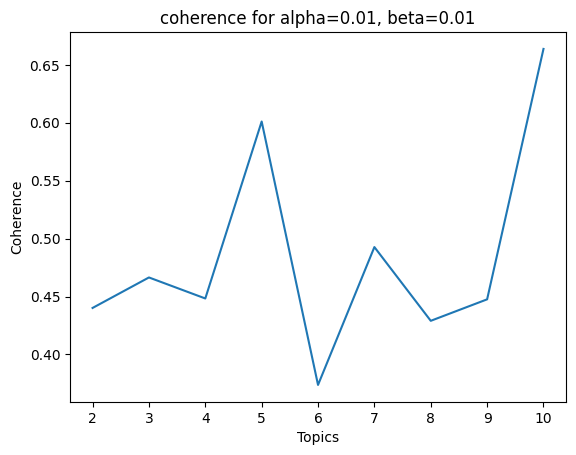

In [ ]:
draw_plot(dfcopy_cafe,0.01,0.01)

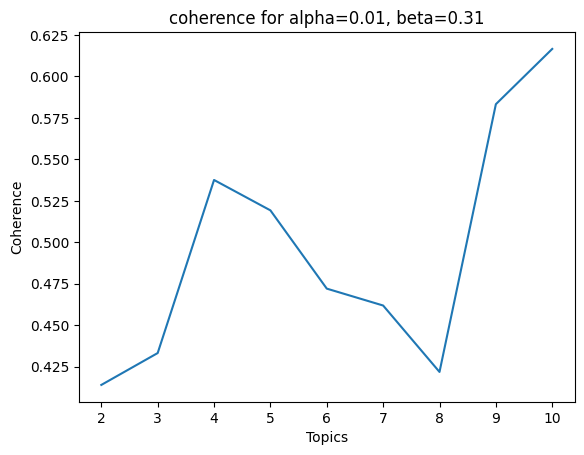

In [ ]:
draw_plot(dfcopy_cafe,0.01,0.31)

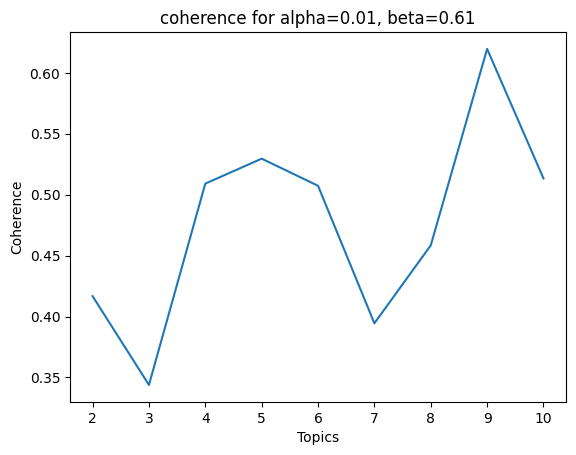

In [ ]:
draw_plot(dfcopy_cafe,0.01,0.61)

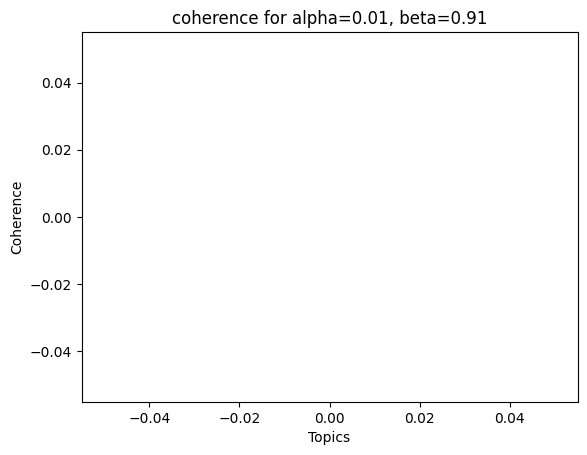

In [ ]:
draw_plot(dfcopy_cafe,0.01,0.91)

In [ ]:
df_topics_cafe10 = dfcopy_cafe[dfcopy_cafe['Topics']==10]
df_topics_cafe10.sort_values(by="Coherence", ascending=False)

,Validation_Set,Topics,Alpha,Beta,Coherence
261,75% Corpus,10,symmetric,0.31,0.785901
260,75% Corpus,10,symmetric,0.01,0.772704
264,75% Corpus,10,symmetric,symmetric,0.758618
530,100% Corpus,10,symmetric,0.01,0.737720
262,75% Corpus,10,symmetric,0.61,0.735138
534,100% Corpus,10,symmetric,symmetric,0.734969
518,100% Corpus,10,0.31,0.91,0.733731
241,75% Corpus,10,0.01,0.31,0.726845
531,100% Corpus,10,symmetric,0.31,0.726562
240,75% Corpus,10,0.01,0.01,0.722826


In [ ]:
df_topics_cafe9 = dfcopy_cafe[dfcopy_cafe['Topics']==9]
df_topics_cafe9.sort_values(by="Coherence", ascending=False)

,Validation_Set,Topics,Alpha,Beta,Coherence
235,75% Corpus,9,asymmetric,0.01,0.774822
507,100% Corpus,9,asymmetric,0.61,0.720618
223,75% Corpus,9,0.61,0.91,0.719284
508,100% Corpus,9,asymmetric,0.91,0.715230
493,100% Corpus,9,0.61,0.91,0.711225
492,100% Corpus,9,0.61,0.61,0.709973
497,100% Corpus,9,0.91,0.61,0.708417
496,100% Corpus,9,0.91,0.31,0.706261
238,75% Corpus,9,asymmetric,0.91,0.702111
227,75% Corpus,9,0.91,0.61,0.696033


In [ ]:
coherence_max_cafe9 = df_topics_cafe9['Coherence'].max()
coherence_max_cafe9

0.8573803650842878

In [ ]:
percent_improved_cafe9 = ((coherence_max_cafe9-coherence_lda_cafe)/coherence_lda_cafe)*100
percent_improved_cafe9

30.66755891706362

In [ ]:
k=9
lda_model_final_cafe = gensim.models.LdaMulticore(corpus=corpus_cafe,
                                           id2word=dictionary_cafe,
                                           num_topics=k,
                                           random_state=100,
                                           chunksize=100,#num of docs to be used each training
                                           passes=100, #num of passes thru corpus during training
                                           alpha=0.61,
                                           eta='auto')

In [ ]:
topics = lda_model_final_cafe.print_topics(num_words=6)
for topic in topics:
    print(topic)

(0, '0.020*"샴푸" + 0.019*"지구" + 0.019*"요기요" + 0.019*"마련" + 0.019*"배달" + 0.019*"성장"')
(1, '0.033*"샴푸" + 0.021*"사용" + 0.020*"제품" + 0.019*"여름" + 0.019*"생각" + 0.019*"이상"')
(2, '0.037*"지구" + 0.036*"제품" + 0.026*"실천" + 0.016*"카페" + 0.014*"우리" + 0.014*"기후변화"')
(3, '0.021*"확대" + 0.012*"제품" + 0.011*"가능" + 0.011*"계획" + 0.011*"플라스틱" + 0.011*"기업"')
(4, '0.129*"사용" + 0.024*"캠페인" + 0.024*"임직원" + 0.024*"숲" + 0.024*"국민" + 0.024*"참여"')
(5, '0.036*"모양" + 0.036*"설거지" + 0.036*"생리대" + 0.036*"패드" + 0.004*"사용" + 0.004*"상품"')
(6, '0.066*"제품" + 0.034*"환경오염" + 0.033*"설치" + 0.033*"처리기" + 0.033*"방식" + 0.014*"사용"')
(7, '0.027*"행동" + 0.015*"관심" + 0.014*"포장" + 0.014*"마트" + 0.014*"제품" + 0.014*"실천"')
(8, '0.042*"문제" + 0.041*"박스" + 0.022*"이산화탄소" + 0.022*"필자" + 0.022*"이론" + 0.022*"자료"')


In [ ]:
# !pip install pyLDAvis


In [ ]:
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

pyLDAvis.enable_notebook()

vis_cafe = gensimvis.prepare(lda_model_final_cafe, corpus_cafe, dictionary_cafe)
pyLDAvis.display(vis_cafe)

In [ ]:
# # Python 버전 확인
# import sys
# print("Python Version:", sys.version)

# # Gensim 버전 확인
# import gensim
# print("Gensim Version:", gensim.__version__)

# # PyLDAvis 버전 확인
# import pyLDAvis
# print("PyLDAvis Version:", pyLDAvis.__version__)


Python Version: 3.10.12 (main, Nov 20 2023, 15:14:05) [GCC 11.4.0]
Gensim Version: 4.3.2
PyLDAvis Version: 3.4.0


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
